조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
문제: 사이킷런을 사용하지 않고 넘파이만으로 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해 보세요. 이를 붓꽃 데이터셋과 같은 분류 작업에 사용해 보세요.

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import numpy as np

In [83]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

데이터를 로드하는 것부터 시작하겠습니다. 앞서 로드한 붓꽃 데이터셋을 재사용하겠습니다.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

In [17]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

In [41]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42)

In [22]:
X[:3]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2]])

In [19]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [76]:
X_b = np.c_[np.ones([len(X), 1]), X]
X_train_b = np.c_[np.ones([len(X_train), 1]), X_train]
X_val_b = np.c_[np.ones([len(X_val), 1]), X_val]
X_test_b = np.c_[np.ones([len(X_test), 1]), X_test]

In [44]:
X_train_b[:3]

array([[1. , 3.9, 1.4],
       [1. , 5.4, 2.1],
       [1. , 1.4, 0.2]])

In [51]:
y_ohe = np.zeros((len(y), 3))
y_ohe[np.arange(len(y)), y] = 1

y_train_ohe = np.zeros((len(y_train), 3))
y_train_ohe[np.arange(len(y_train)), y_train] = 1

y_val_ohe = np.zeros((len(y_val), 3))
y_val_ohe[np.arange(len(y_val)), y_val] = 1

In [52]:
y_train_ohe[:3]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [47]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

In [48]:
def cross_entropy_loss(y_pred, y_ohe):
    m = len(y_ohe)
    loss = - (1/m) * np.sum(y_ohe * np.log(y_pred + 1e-7))
    return loss

In [101]:
eta = 0.1
n_epochs = 500
m, n_features = X_train_b.shape
theta = None
theta_best = None

In [96]:
def fit(X, y, X_val, y_val):
    np.random.seed(42)
    theta = np.random.randn(n_features,3) / np.sqrt(n_features)

    loss_best = np.inf
    ewi = 0

    for epoch in range(n_epochs):
        logits_train = X_train_b.dot(theta)
        y_train_pred = softmax(logits_train)
        gradient = (1/m)*X_train_b.T.dot(y_train_pred-y_train_ohe)
        theta = theta - eta*gradient

        logits_val = X_val_b.dot(theta)
        y_val_pred = softmax(logits_val)

        val_loss = cross_entropy_loss(y_val_pred, y_val_ohe)

        if val_loss < loss_best:
            loss_best = val_loss
            theta_best = theta.copy()
            ewi = 0
        else:
            ewi += 1
        if ewi >= 5:
            break
    theta = theta_best
    if theta is None:
        theta = theta
    return theta



In [102]:
learned_theta = fit(X_train_b, y_train_ohe, X_val_b, y_val_ohe)
learned_theta

array([[ 3.48490044, -0.28310885, -2.62089732],
       [-0.57572797,  0.57680146,  0.60788065],
       [-0.81001848,  0.1963493 ,  1.69745561]])

In [103]:
y_proba = softmax(X_test_b.dot(learned_theta))
y_pred = np.argmax(y_proba, axis=1)

In [104]:
accuracy = np.mean(y_pred == y_test)
print(f"테스트 세트 정확도: {accuracy * 100:.2f}%")

테스트 세트 정확도: 89.47%


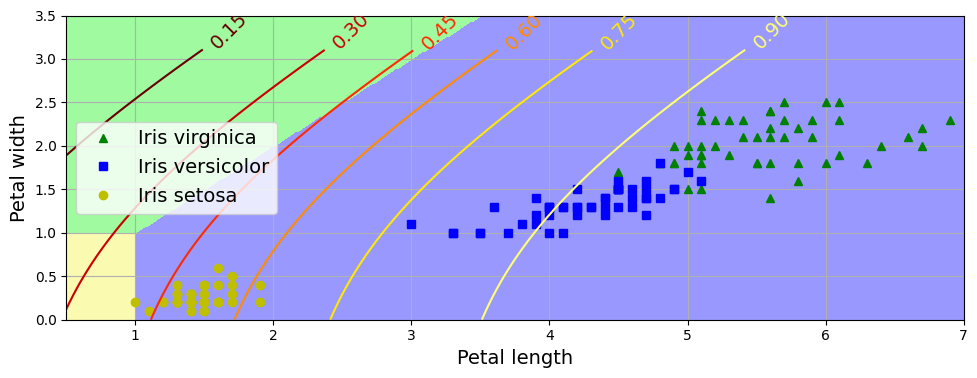

In [105]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax(np.c_[np.ones([len(X_new), 1]), X_new])
y_pred = np.argmax(y_proba, axis=1)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_pred.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()